<h1><strong>Downsampling Experiment</strong></h1>

In [40]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
from score import GaussianScore
import importlib
import score
importlib.reload(score)

<module 'score' from '/home/mtemoschenko/TFE/score.py'>

<h2>Load Model</h2>

In [41]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_160.pth"

In [55]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }

Using device: cuda
Spatial Encoding Shape : torch.Size([4, 64, 64])
Channels : 24


In [43]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_2076163/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_160.pth, trained until epoch 160


<h2> A(x_(x(t)) </h2>

In [44]:
def downscale(batch, mask, patch_size, device='cpu'):
    if batch.shape[0] == 1 and batch.dim() == 5:
        return batch.squeeze(0)
    print(f"batch : {batch.shape}")
    B1, B2, H, W = batch.shape
    new_H, new_W = H // patch_size, W // patch_size
    
    patches = batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # (B1, B2, new_H, new_W, patch_size, patch_size)
    print(mask.shape)
    myMask = mask[0]
    mask_patches = myMask.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
    print(patches.shape)
    print(mask_patches.shape)
    valid_patches = patches * mask_patches.unsqueeze(0).unsqueeze(0)  # Apply mask
    valid_counts = mask_patches.sum(dim=(-2, -1), keepdim=True)
    
    valid_counts = torch.where(valid_counts == 0, torch.tensor(1, device=device), valid_counts)
    downscaled_grid = valid_patches.sum(dim=(-2, -1)) / valid_counts.squeeze(-1).squeeze(-1)
    downscaled_mask = mask_patches.any(dim=(-2, -1))
    print(downscaled_mask.shape)
    
    upsampled_batch = downscaled_grid.repeat_interleave(patch_size, dim=-1).repeat_interleave(patch_size, dim=-2)
    upsampled_mask = downscaled_mask.repeat_interleave(patch_size, dim=-1).repeat_interleave(patch_size, dim=-2)
    upsampled_batch = upsampled_batch * mask
    return upsampled_batch

batch : torch.Size([5, 24, 64, 64])
torch.Size([1, 64, 64])
torch.Size([5, 24, 8, 8, 8, 8])
torch.Size([8, 8, 8, 8])
torch.Size([8, 8])
torch.Size([10, 24, 64, 64])
torch.Size([10, 2, 12, 64, 64])
torch.Size([10, 2, 12, 64, 64])
Input shape: torch.Size([10, 2, 12, 64, 64])
T2m  Mean : -0.11693741381168365, Var: 1.5078157186508179
U10m  Mean : 2.2034037113189697, Var: 0.6047074198722839
T2m  Mean : -0.11693736910820007, Var: 1.4163930416107178
U10m  Mean : 2.2034037113189697, Var: 0.42026886343955994
T2m  Mean : 18.872764587402344, Var: 4.008213996887207
U10m  Mean : 4.290159702301025, Var: 1.5480276346206665
T2m  Mean : 18.872764587402344, Var: 3.936570405960083
U10m  Mean : 4.290159702301025, Var: 1.330658197402954
T2m  Mean : 6.485018253326416, Var: 2.332369327545166
U10m  Mean : 2.7532143592834473, Var: 0.7569462060928345
T2m  Mean : 6.485018253326416, Var: 2.2700419425964355
U10m  Mean : 2.7532143592834473, Var: 0.6200331449508667
T2m  Mean : 19.45572280883789, Var: 2.9162786006927

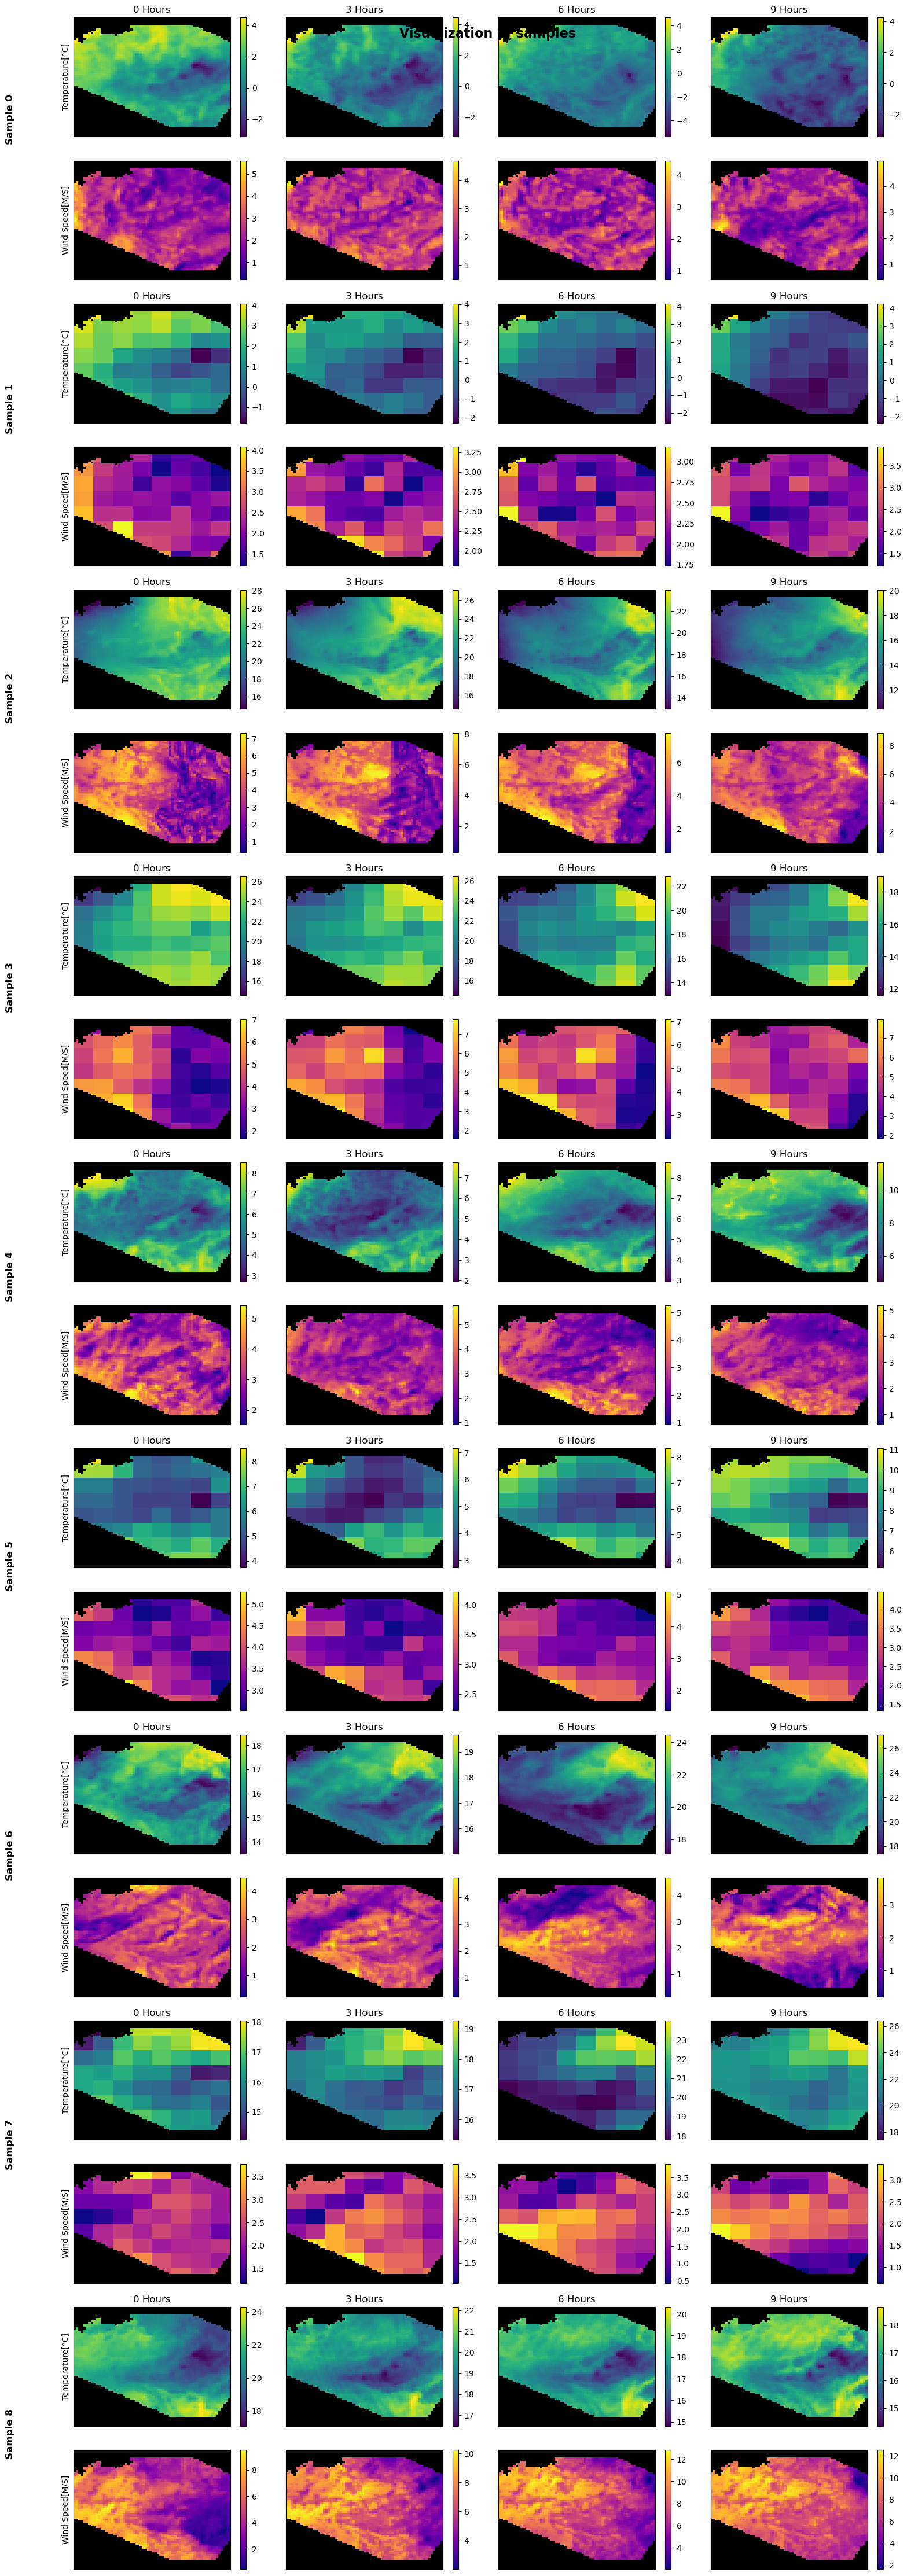

In [45]:
batch, dic = next(iter(testloader))
batch = batch.cpu()
new_tensor = torch.stack((batch,downscale(batch,mask_cpu,8)), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)


batch : torch.Size([5, 24, 64, 64])
torch.Size([1, 64, 64])
torch.Size([5, 24, 4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4])
torch.Size([5, 24, 64, 64])
torch.Size([5, 2, 12, 64, 64])
torch.Size([5, 2, 12, 64, 64])
Input shape: torch.Size([5, 2, 12, 64, 64])
T2m  Mean : 0.8037799596786499, Var: 1.726053237915039
U10m  Mean : 1.8441522121429443, Var: 0.6375687718391418
T2m  Mean : 4.89883279800415, Var: 0.9732862114906311
U10m  Mean : 3.0300588607788086, Var: 0.8204068541526794
T2m  Mean : 6.609859943389893, Var: 0.9882399439811707
U10m  Mean : 6.345215797424316, Var: 1.657131552696228


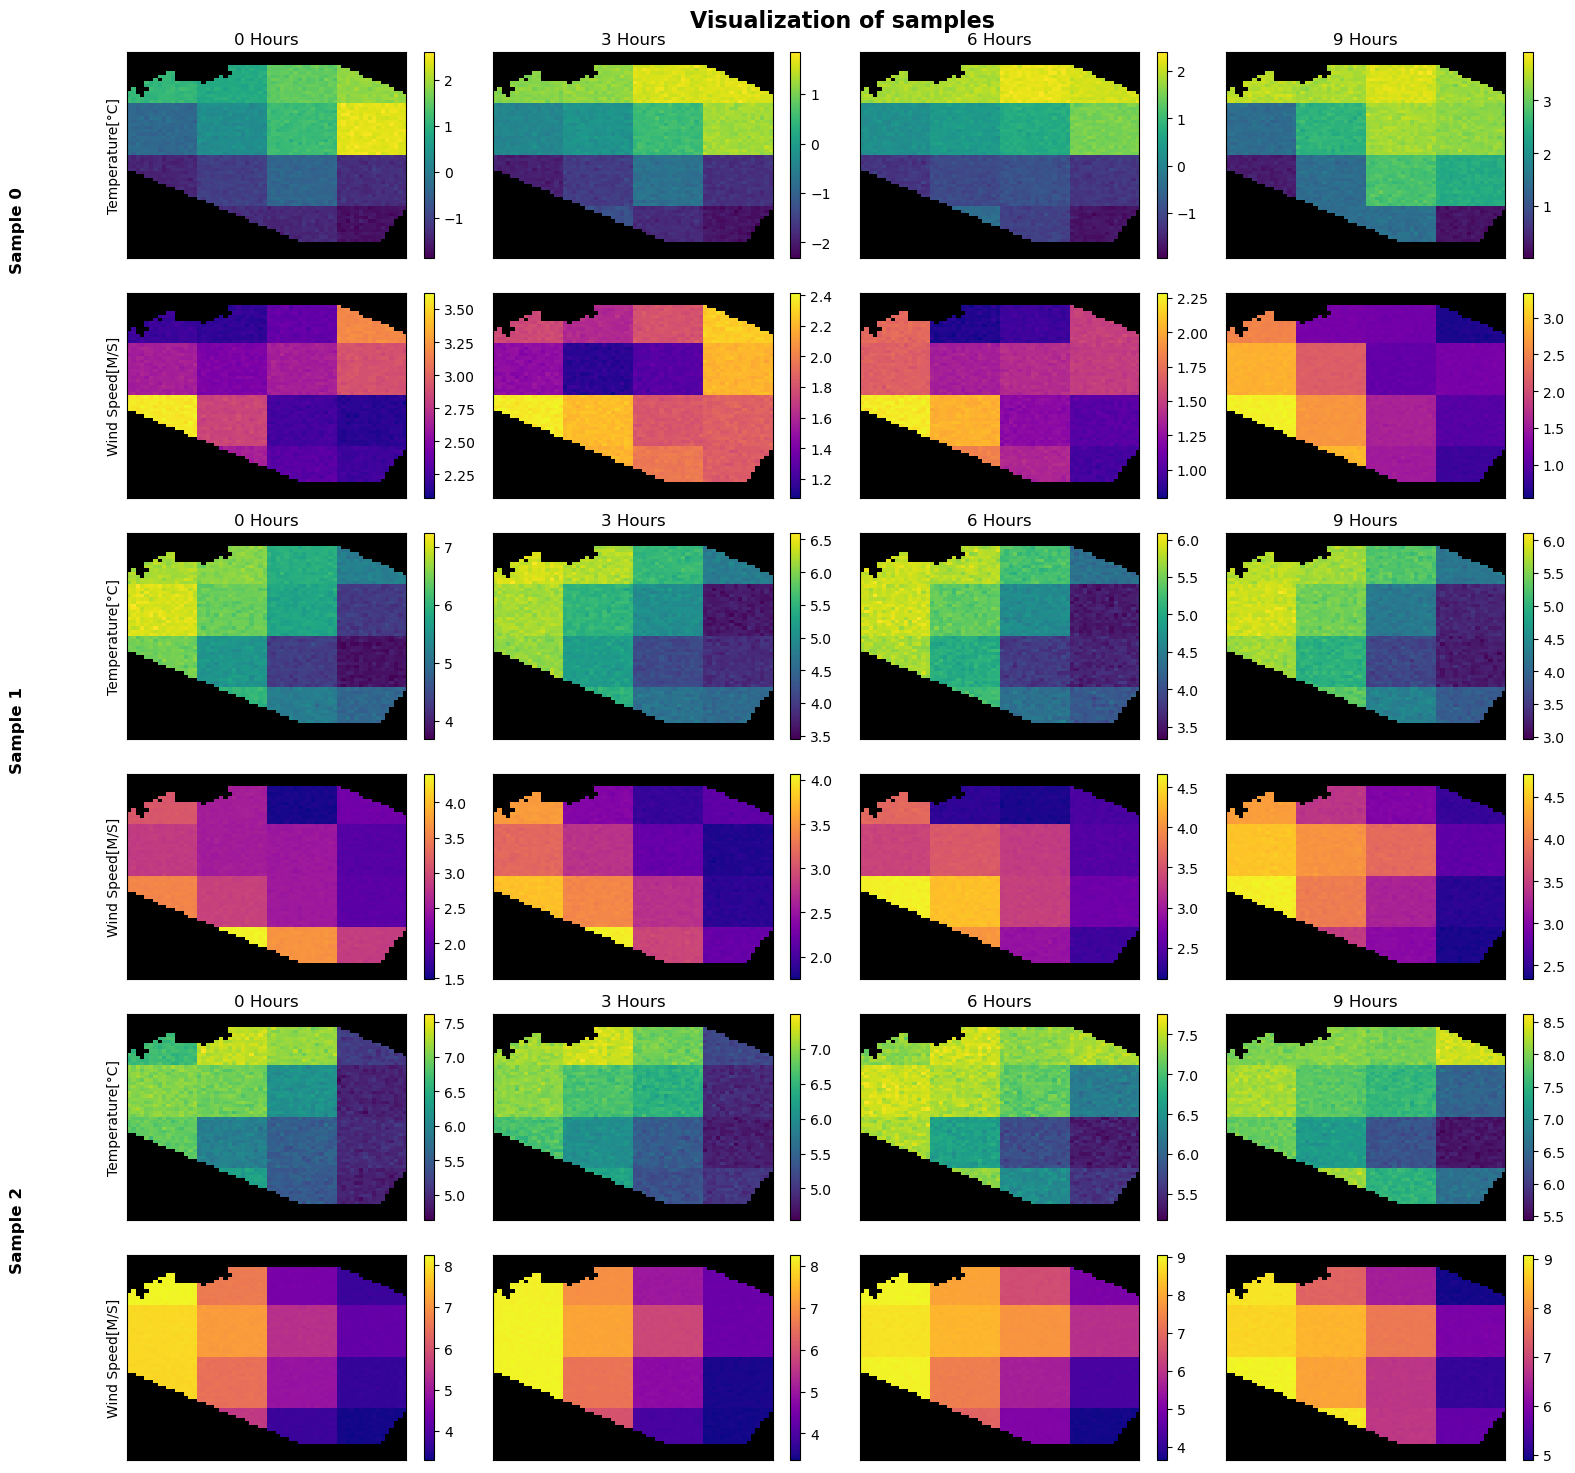

In [125]:
def A(x):
    return downscale(x,mask,16)
x_star, c_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = c_star['context'].to(device)
y_star = torch.normal(A(x_star), 1e-2)*mask

info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(y_star.detach().cpu(),info,mask_cpu,samples=3,step=3, unnormalize=True, path_unnorm = path_unnorm)

<h1><bold>Visualization of Experience </bold> </h1>

In [126]:
importlib.reload(score)
sde = VPSDE(score.DPSGaussianScore(y_star,mask, A=A,  sde=vpsde, zeta=4.7), shape=x_star.shape).cuda()

In [133]:
x = sde.sample(mask,shape=(1,), c=c_star, steps=64, corrections=8, tau=0.5).cpu()


100%|███████████████████████████████████████████████████| 64/64 [00:26<00:00,  2.39it/s]


torch.Size([15, 24, 64, 64])
torch.Size([15, 2, 12, 64, 64])
torch.Size([15, 2, 12, 64, 64])
Input shape: torch.Size([15, 2, 12, 64, 64])
T2m  Mean : 0.8036695122718811, Var: 1.9104417562484741
U10m  Mean : 1.8441883325576782, Var: 0.8531518578529358
T2m  Mean : 0.8037799596786499, Var: 1.726053237915039
U10m  Mean : 1.8441522121429443, Var: 0.6375687718391418
T2m  Mean : 0.6496204733848572, Var: 0.9133563041687012
U10m  Mean : 1.8326598405838013, Var: 0.700620174407959
T2m  Mean : 4.898854732513428, Var: 1.0964555740356445
U10m  Mean : 3.030005931854248, Var: 0.9836177825927734
T2m  Mean : 4.89883279800415, Var: 0.9732862114906311
U10m  Mean : 3.0300588607788086, Var: 0.8204068541526794
T2m  Mean : 4.777685642242432, Var: 1.2806520462036133
U10m  Mean : 3.1339588165283203, Var: 0.9309485554695129
T2m  Mean : 6.610907554626465, Var: 1.1505968570709229
U10m  Mean : 6.345353126525879, Var: 1.910573959350586
T2m  Mean : 6.609859943389893, Var: 0.9882399439811707
U10m  Mean : 6.34521579742

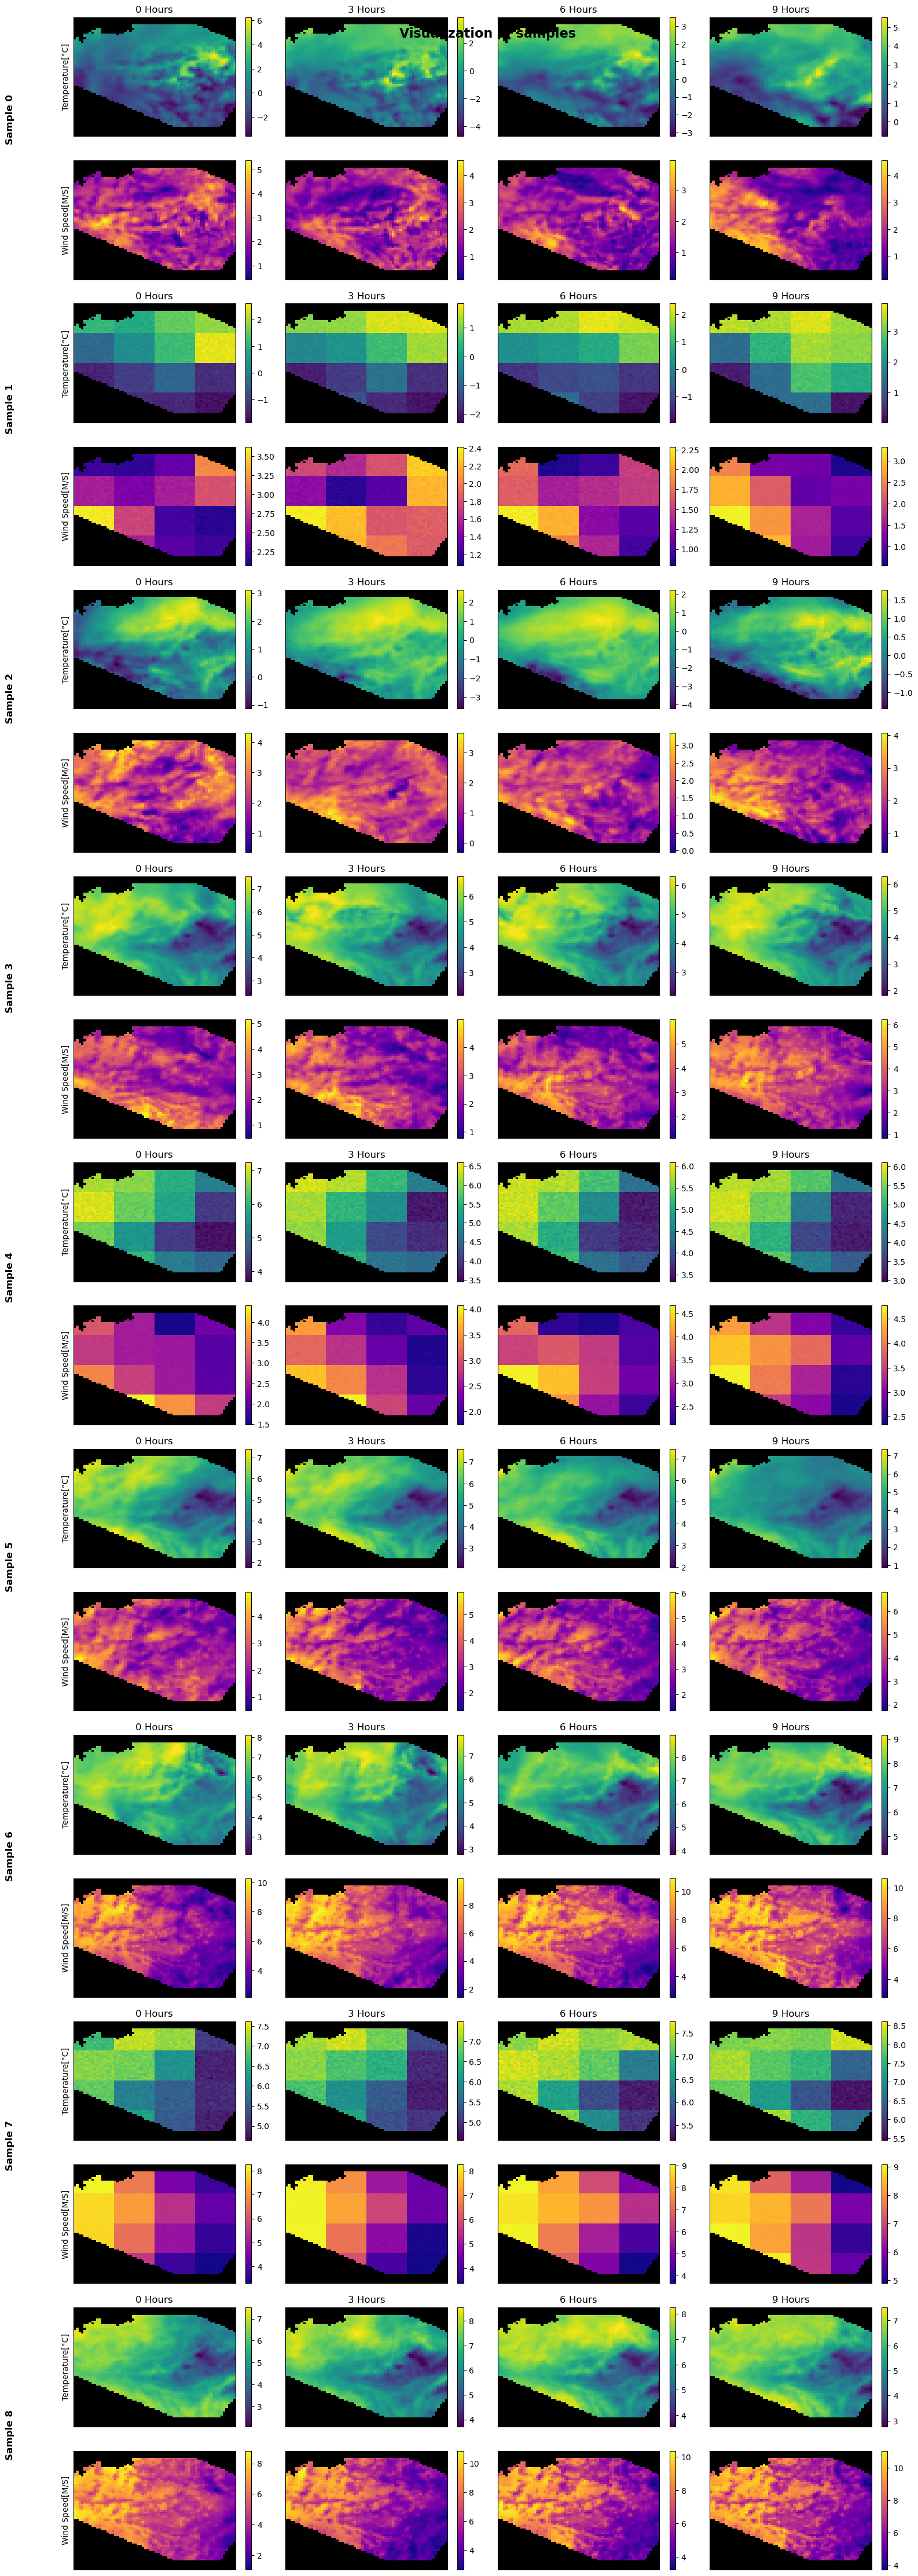

In [134]:
x_ = x[0]
# Good parameters : zeta: 4.5, steps: 48, corrections: 3
new_tensor = torch.stack((x_star.detach().cpu(),y_star.detach().cpu(),x_), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)